# Introduction to PyTorch

**Nicolas Nytko**  
nnytko2@illinois.edu  
https://github.com/nicknytko/siam-pytorch-workshop

Adapted from materials by Matthew West (mwest@illinois.edu)

_SIAM @ Illinois workshop series_

November 12, 2024

**Description:** PyTorch allows you to easily train and run machine learning models. It uses standard Python methods for writing code, so it's both simple and powerful. We will cover the core automatic differentiation capabilities of PyTorch, training deep neural networks, managing training and test data, saving and loading models, and show a few examples of neural network implementations. We will assume a good knowledge of Python and NumPy, and basic knowledge of machine learning with neural nets.

# List of resources

- PyTorch tutorials: https://pytorch.org/tutorials/
- PyTorch manual: https://pytorch.org/docs/stable/index.html
- PyTorch paper: https://openreview.net/forum?id=BJJsrmfCZ
- Calculus in Machine Learning: https://machinelearningmastery.com/calculus-in-machine-learning-why-it-works/
- Calculus on computational graphs: http://colah.github.io/posts/2015-08-Backprop/
- Einstein summation in PyTorch: https://rockt.github.io/2018/04/30/einsum

# First, some math background

Three main "approaches" to machine learning:
- Supervised learning
- Unsupervised learning
- Reinforcement learning

We'll focus on supervised learning, though what we'll show here will be applicable to all 3.

Let's say we have some unknown function $f : \mathbb{R}^m \to \mathbb{R}^n$; for example, a function that takes an image and outputs $1$ if it contains a cat, and $0$ otherwise.

![](https://github.com/nicknytko/siam-pytorch-workshop/blob/main/figures/f_catdog.png?raw=1)

<small> Dog photo from https://www.pickpik.com/dog-puppy-cute-adorable-pet-cute-puppy-59501 </small>

This is pretty easy for humans to determine!  However, we don't know what such a function "looks like" nor how we would implement it on a computer.  So, we seek an approximate function $\hat{f} \approx f$ where $\hat{f}$ is much easier for us to evaluate.

Here's a smaller example with a linear regression.

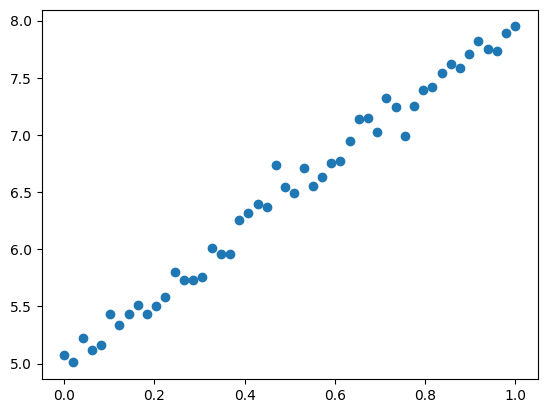

In [1]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 1, 50)
f = 5 + 3*x + np.random.randn(50)*0.1

plt.plot(x, f, 'o')

Here, the output of $f$ is displayed for a few values of $x$.  This is pretty simple, but useful for demonstration!  Let us try to fit a $\hat{f}$ that approximates $f$ closely.  Lets assume $\hat{f}$ is a linear function of the form
$$ \hat{f}(x; m, b) = mx + b. $$
One way of forcing $\hat{f} \approx f$ is to minimize the function
$$ \ell(m, b) = \sum_i (f(x_i, m, b) - f(x))^2 = \sum_i (mx_i + b - f(x))^2 $$
How do we do this?  Recall from calculus that to find the minimum of a function, we can take the derivatives and solve for $0$.

$$\begin{align*}
\frac{\partial \ell}{\partial m} &= \sum_i 2x_i(mx_i + b - f(x)) \\
\frac{\partial \ell}{\partial b} &= \sum_i 2(mx_i + b - f(x))
\end{align*}$$

Numerically, we can implement this using *gradient descent*.  We start with some random initial values of $m, b$ and update like
$$\begin{align*}
m &\gets m - \alpha \frac{\partial \ell}{\partial m}(m, b), \\
b &\gets b - \alpha \frac{\partial \ell}{\partial b}(m, b),
\end{align*}$$
where $\alpha \in \mathbb{R}^+$ is some small parameter called the *learning rate*.  Lets see it in action:

In [2]:
# Start with an arbitrary guess for the slope and bias
m = 1.0
b = 0.0

alpha = 0.01

Loss: 0.956
Derivatives: 2.264e+00 -1.138e+00
m: 3.297, b: 4.835


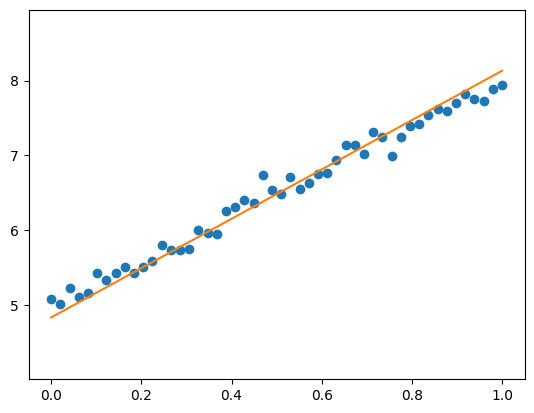

In [10]:
# Compute derivatives
dl_dm = np.sum(2 * x * (m * x + b - f))
dl_db = np.sum(2 * (m * x + b - f))

# Descend
m -= dl_dm * alpha
b -= dl_db * alpha

# Plot the results
f_hat = m * x + b

plt.plot(x, f, 'o')
plt.plot(x, f_hat)
plt.ylim(np.min(f) - 1, np.max(f) + 1)

print(f'Loss: {np.sum((f_hat - f) ** 2):.3f}')
print(f'Derivatives: {dl_dm:.3e} {dl_db:.3e}')
print(f'm: {m:.3f}, b: {b:.3f}')

This is the basic idea behind supervised learning!  Of course, we did everything by hand, like taking the derivatives and performing gradient descent, which is a lot of work as our models will get more complex.  As we'll see, PyTorch can implement much of this for us.

# Let's get started with PyTorch!

In [11]:
import torch
import torch.linalg as tla
import random, datetime

In [12]:
x = torch.tensor([1.0, 2.0, 3.0])

In [13]:
x

tensor([1., 2., 3.])

In [14]:
x ** 2

tensor([1., 4., 9.])

In [15]:
torch.cos(x)

tensor([ 0.5403, -0.4161, -0.9900])

In [16]:
tla.norm(x)

tensor(3.7417)

In [17]:
x**2

tensor([1., 4., 9.])

In [18]:
x.dtype

torch.float32

#### Specify datatypes

Use `dtype=torch.float64` and `.double()`

In [19]:
y = x.double()
y

tensor([1., 2., 3.], dtype=torch.float64)

In [20]:
y.dtype

torch.float64

In [21]:
y.float()

tensor([1., 2., 3.])

In [22]:
y.int()

tensor([1, 2, 3], dtype=torch.int32)

In [23]:
x = torch.tensor([1, 2, 3])

In [24]:
torch.log(x)

tensor([0.0000, 0.6931, 1.0986])

In [25]:
x.dtype

torch.int64

In [26]:
x = torch.tensor([1, 2, 3], dtype=torch.float64)

In [27]:
torch.log(x)

tensor([0.0000, 0.6931, 1.0986], dtype=torch.float64)

# `torch.autograd`: Computing derivatives

PyTorch constructs the computation graph as you do operations (dynamic graphs) unlike TensorFlow (static graphs)

Using the computation graph, the chain rule (back propagation) can compute derivatives

Derivatives are available in the leaf nodes

![](https://github.com/nicknytko/siam-pytorch-workshop/blob/main/figures/computation_graph.jpg?raw=1)

<small>Figure from http://datahacker.rs/004-computational-graph-and-autograd-with-pytorch/</small>

In [28]:
x = torch.tensor(5.0)

In [31]:
y = torch.tensor(3.0, requires_grad=True)

In [30]:
z = x * y**2
z

tensor(45., grad_fn=<MulBackward0>)

In [32]:
z.backward()

In [33]:
print(f'x.grad = {x.grad}')

x.grad = None


In [35]:
y.grad

$z = x y^2$

$\frac{\partial z}{\partial y} = 2 x y$

In [36]:
2*x*y

tensor(30., grad_fn=<MulBackward0>)

#### Control what we differentiate with respect to

`requires_grad=True`

`with no_grad():`

`.detach()`

In [37]:
x = torch.tensor(2.0, requires_grad=True)
y = x*x
print(f'y.requires_grad = {y.requires_grad}')
z = x*y
z.backward()
print(f'dz/dx = {x.grad}')

y.requires_grad = True
dz/dx = 12.0


In [38]:
x = torch.tensor(2.0, requires_grad=True)
y = x*x
y = y.detach() # can't say y.requires_grad = False
print(f'y.requires_grad = {y.requires_grad}')
z = x*y
z.backward()
print(f'dz/dx = {x.grad}')

y.requires_grad = False
dz/dx = 4.0


In [39]:
x = torch.tensor(2.0, requires_grad=True)
with torch.no_grad():
    y = x*x
print(f'y.requires_grad = {y.requires_grad}')
z = x*y
z.backward()
print(f'dz/dx = {x.grad}')

y.requires_grad = False
dz/dx = 4.0


#### Computation graphs are not trees

Re-using a parameter in multiple places makes the graph not be a tree. It's a DAG.

In [43]:
x = torch.tensor(2.0, requires_grad=True)
y = 3*x
z = x**2
w = y + z + x
w.backward()
x.grad

tensor(8.)

$\frac{\partial w}{\partial x} = \frac{\partial}{\partial x}(3x + x^2 + x) = 3 + 2x + 1$

In [44]:
3 + 2*x + 1

tensor(8., grad_fn=<AddBackward0>)

#### The computation graph is destroyed by `backward()`

To retain it for more differentiation, use `backward(retain_graph=True)`

A common use case is multiple outputs with a shared subgraph

Don't forget to free the graph on the last call to prevent memory leaks

In [45]:
x = torch.tensor(3.0, requires_grad=True)
y = x**2
z1 = 3*y
z2 = 4*y

In [46]:
z1.backward() # (retain_graph=True)
x.grad

tensor(18.)

In [47]:
z2.backward()
x.grad

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

#### Derivatives of scalars with respect to tensors

In [48]:
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
y = (x**2).sum()
y.backward()
x.grad

tensor([2., 4., 6.])

#### Don't do in-place modifications to tensors

But it's fine to do `x = 4 * x`

In [49]:
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
x

tensor([1., 2., 3.], requires_grad=True)

In [50]:
x[1] = x[2] + 1
#x = 4*x
x

RuntimeError: a view of a leaf Variable that requires grad is being used in an in-place operation.

In [51]:
y = (x**2).sum()
y.backward()

#### Results can be slightly different from what you expect...

Since we're building the graph as computations are being done, functions like `max()` become differentiable

In [52]:
x = torch.tensor([1.0, 2.0, 4.0, 3.0, 0.5], requires_grad=True)
max_x = torch.max(x)
max_x

tensor(4., grad_fn=<MaxBackward1>)

In [53]:
max_x.backward()
x.grad

tensor([0., 0., 1., 0., 0.])

# `torch.optim`: All the common gradient-based optimizers

In [56]:
def f(x):
    return x**2

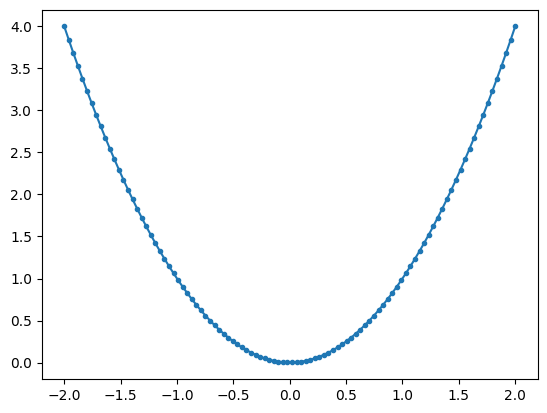

In [55]:
xvec = np.linspace(-2, 2, 100)
fvec = f(xvec)
plt.plot(xvec, fvec, 'o-', markersize=3)

In [77]:
x = torch.tensor([2.0], requires_grad=True)

In [78]:
opt = torch.optim.SGD([x], lr=0.15)

In [79]:
x_history = [x.detach().numpy().copy()]
for i in range(30):
    print(f'##########')
    print(f'i = {i}')
    print(f'initial x = {x}')
    opt.zero_grad()
    z = f(x)
    print(f'f(x) = {z}')
    z.backward()
    print(f'x.grad = {x.grad}')
    opt.step()
    print(f'updated x = {x}')
    x_history.append(x.detach().numpy().copy())

##########
i = 0
initial x = tensor([2.], requires_grad=True)
f(x) = tensor([4.], grad_fn=<PowBackward0>)
x.grad = tensor([4.])
updated x = tensor([1.4000], requires_grad=True)
##########
i = 1
initial x = tensor([1.4000], requires_grad=True)
f(x) = tensor([1.9600], grad_fn=<PowBackward0>)
x.grad = tensor([2.8000])
updated x = tensor([0.9800], requires_grad=True)
##########
i = 2
initial x = tensor([0.9800], requires_grad=True)
f(x) = tensor([0.9604], grad_fn=<PowBackward0>)
x.grad = tensor([1.9600])
updated x = tensor([0.6860], requires_grad=True)
##########
i = 3
initial x = tensor([0.6860], requires_grad=True)
f(x) = tensor([0.4706], grad_fn=<PowBackward0>)
x.grad = tensor([1.3720])
updated x = tensor([0.4802], requires_grad=True)
##########
i = 4
initial x = tensor([0.4802], requires_grad=True)
f(x) = tensor([0.2306], grad_fn=<PowBackward0>)
x.grad = tensor([0.9604])
updated x = tensor([0.3361], requires_grad=True)
##########
i = 5
initial x = tensor([0.3361], requires_grad=True)
f

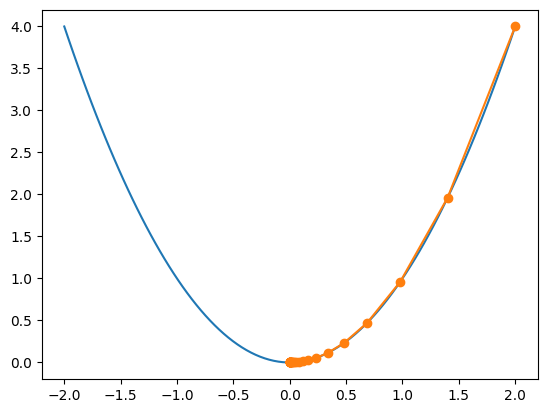

In [80]:
xvec = np.linspace(-2, 2, 100)
fvec = f(xvec)
plt.plot(xvec, fvec)
plt.plot(x_history, f(np.array(x_history)), 'o-')

# `torch.nn`: Lets implement a neural network!

Recall from the first example, we implemented a linear model to approximate some noisy data.

What happens if we compose multiple linear models together?

$$\begin{align*}
f_1{\bf x} &= {\bf W}_1 {\bf x} + {\bf b}_1 \\
f_2{\bf x} &= {\bf W}_2 {\bf x} + {\bf b}_2 \\
\hat{f}({\bf x}) &= f_2(f_1({\bf x})) = {\bf W}_2({\bf W}_1 {\bf x} + {\bf b}_1) + {\bf b}_2
\end{align*}$$

If we distribute terms out, we get something that's still linear in ${\bf x}$!  
$$ \hat{f}({\bf x}) = {\bf W}_2({\bf W}_1 {\bf x} + {\bf b}_1) + {\bf b}_2 = {\bf W}_2 {\bf W}_1 {\bf x} + {\bf W}_2 {\bf b}_1 + {\bf b}_2 $$

This means that ultimately stacking many linear models together does not give us something more expressive.  However, we can introduce a nonlinearity in terms of an *activation function*.  There are many choices, like

$$\begin{align*}
\text{ReLU}({\bf x})_i &= \max\{x_i, 0\} \\
\sigma({\bf x})_i &= e^x/(1 + e^x) \\
\text{Softplus}({\bf x})_i &= \ln(1+e^x) \\
&\enspace\vdots
\end{align*}$$

and many more.  We'll stick to ReLU here as it's pretty simple.  Adding these nonlinear functions to our model, we get
$$\begin{align*}
f_1{\bf x} &= \text{ReLU}({\bf W}_1 {\bf x} + {\bf b}_1) \\
f_2{\bf x} &= \text{ReLU}({\bf W}_2 {\bf x} + {\bf b}_2) \\
\hat{f}({\bf x}) &= f_2(f_1({\bf x})) = \text{ReLU}({\bf W}_2\text{ReLU}({\bf W}_1 {\bf x} + {\bf b}_1) + {\bf b}_2)
\end{align*}$$
Notice this is no longer linear in ${\bf x}$.  Lets go ahead and implement this in PyTorch.

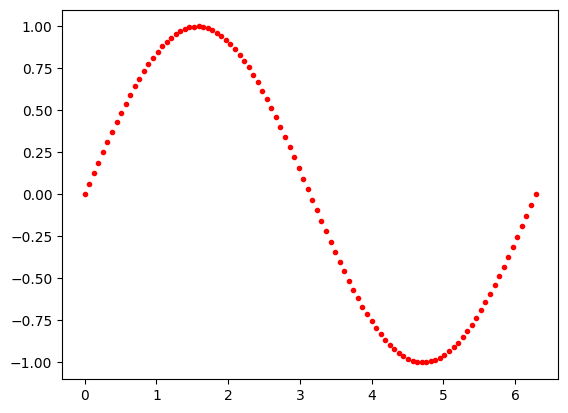

In [113]:
x = torch.linspace(0, 2*np.pi, 100)
y = torch.sin(x)
plt.plot(x.numpy(), y.numpy(), 'r.');

In [114]:
class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        N = 8
        self.fc1 = torch.nn.Linear(1, N)
        self.fc2 = torch.nn.Linear(N, N)
        self.fc3 = torch.nn.Linear(N, 1)

    def forward(self, x):
        x = x.reshape((-1, 1)) # We'll reshape this to a column vector
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x.flatten()

In [115]:
model = MyModel()

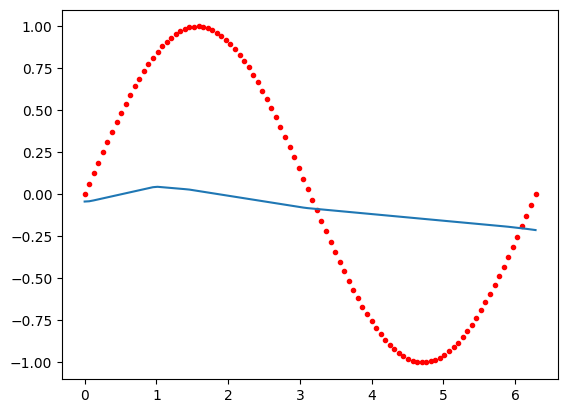

In [116]:
yp = model(x)

plt.plot(x.numpy(), y.numpy(), 'r.');
plt.plot(x.numpy(), yp.detach().numpy());

In [117]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)
loss_history = []

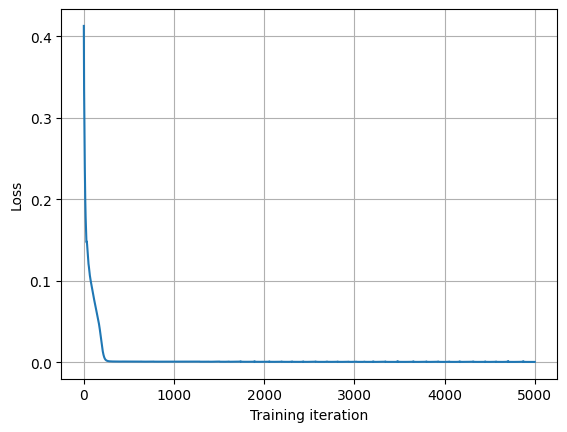

In [118]:
for i in range(5000):
    # Remember the steps on how to write an optimization loop
    # 1. zero out the optimizer's gradients
    # 2. evaluate the model
    # 3. compute loss
    # 4. backpropagate gradients on the loss
    # 5. take a step with the optimizer

    # Fill me out!
    opt.zero_grad()
    y_eval = model(x)

    # we use a mean squared loss
    loss = torch.mean((y_eval - y)**2.)
    loss_history.append(loss.item())

    loss.backward()
    opt.step()

plt.plot(loss_history)
plt.xlabel('Training iteration')
plt.ylabel('Loss')
plt.grid()

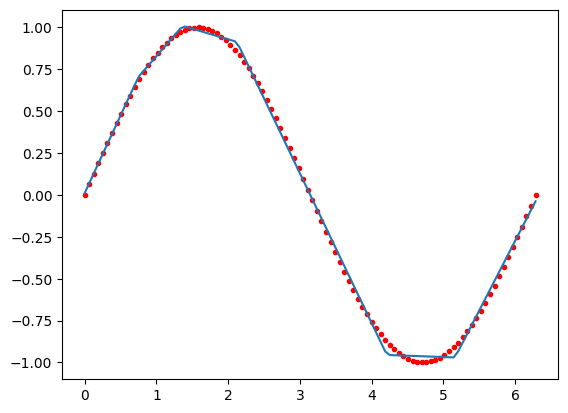

In [119]:
plt.plot(x.numpy(), y.numpy(), 'r.');
plt.plot(x.numpy(), y_eval.detach().numpy());

# Saving and restoring models

Save and load the parameters, not the full models.

In [93]:
torch.save(model.state_dict(), 'model_file.pth')

In [94]:
model = MyModel()
model.load_state_dict(torch.load('model_file.pth', weights_only=True))

<All keys matched successfully>

In [95]:
model.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 0.1508],
                      [-0.7789],
                      [ 0.2099],
                      [ 0.0036],
                      [-0.3776],
                      [-0.8588],
                      [ 0.8544],
                      [-0.6600]])),
             ('fc1.bias',
              tensor([ 0.7157, -0.5959, -0.2884, -0.1839,  0.5116, -0.3142, -0.0733,  0.6999])),
             ('fc2.weight',
              tensor([[-0.0332,  0.1901, -0.2799, -0.2757, -0.3376,  0.2051,  0.3266,  0.2960],
                      [ 0.0480,  0.1767,  0.2418,  0.2134,  0.1531, -0.2348, -0.1979,  0.3511],
                      [ 0.0093,  0.2978,  0.2489, -0.1508,  0.0823,  0.0467, -0.2479,  0.1917],
                      [ 0.0070,  0.0109, -0.2748, -0.3182,  0.3493,  0.1223,  0.1651,  0.1455],
                      [ 0.1651, -0.0644,  0.0731, -0.0109, -0.0741, -0.0957, -0.0426, -0.2642],
                      [ 0.1067, -0.0378, -0.2873, -0.1446,  0.0763,  0.010